In [1]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: e1071

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘DynDoc’


The following object is ma

In [2]:
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [3]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)



[1] 1874

In [4]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...

preparing IC data...



# ABM analysis

## load data

509 genes excluded.


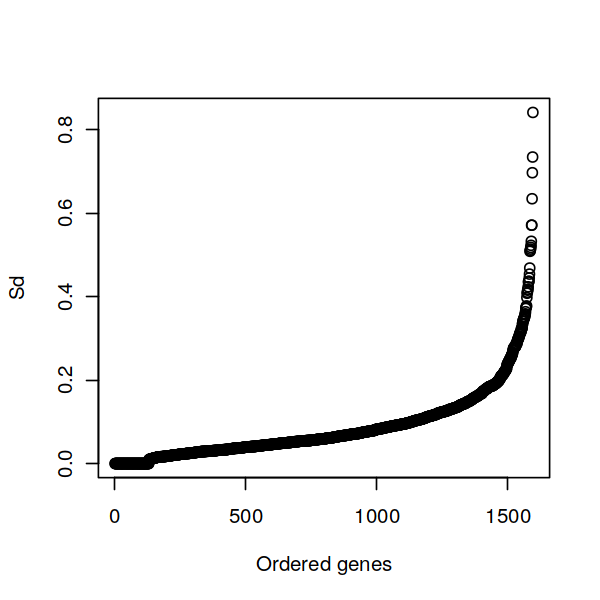

In [5]:
# 1. load data
o(5,5)
goi = alp1.hvg
mat = read.csv('./221112-ABM-aLP1_5to2-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

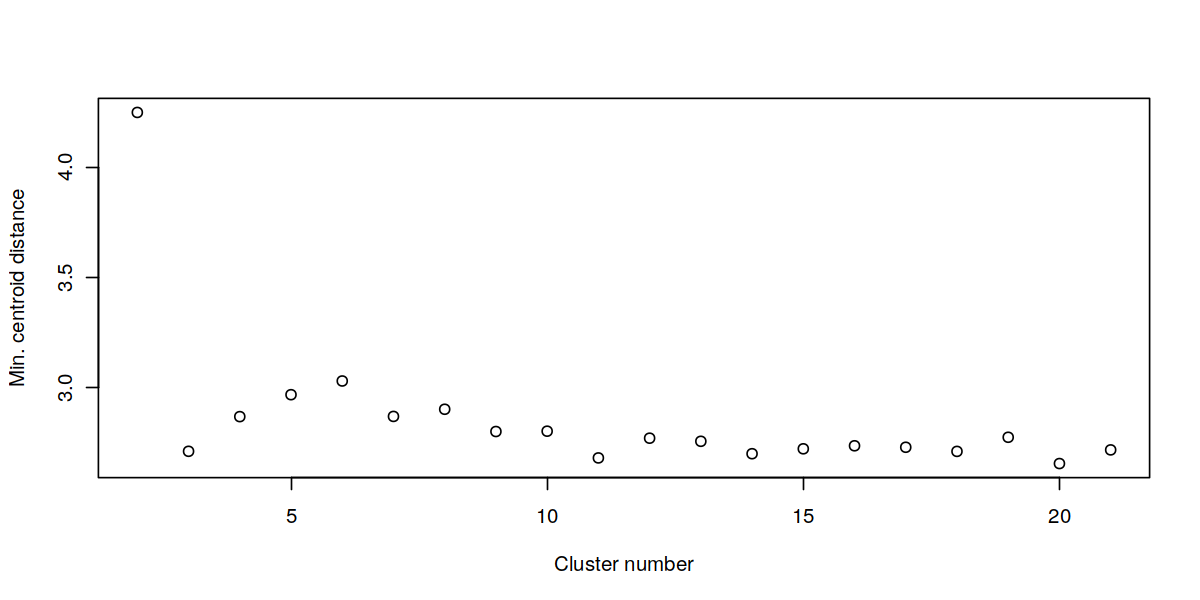

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Warning message:
“Ignoring unknown aesthetics: order”


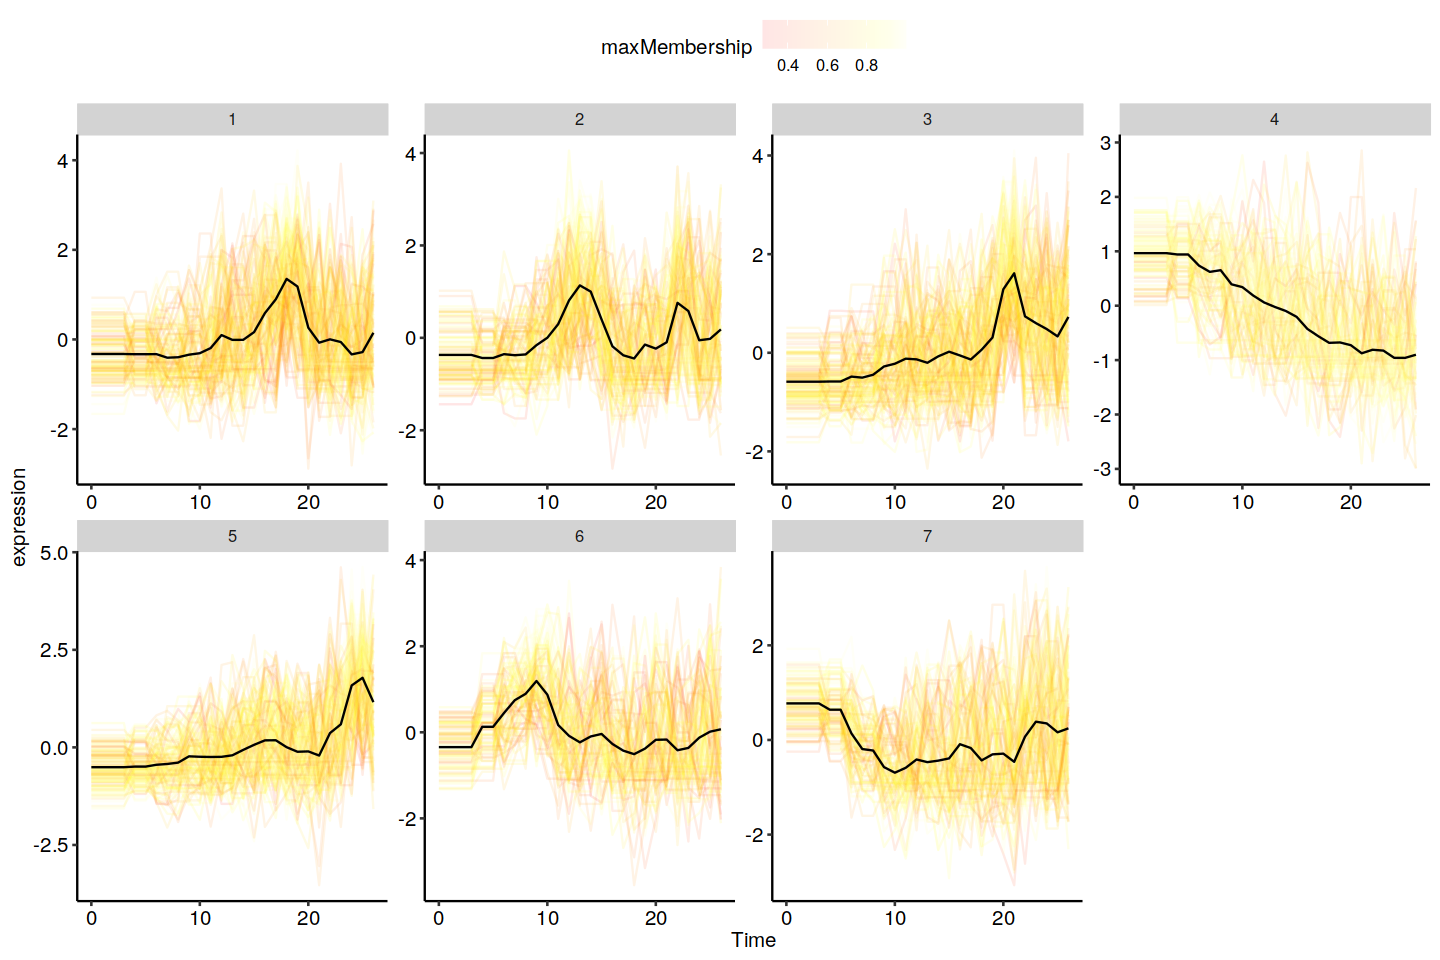

In [15]:
# 3. do clustering and show
c <- 7 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(3*4,4*2)
mfuzz.plot( eset,cl,mfrow=c(2,4), new.window= FALSE)


o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

In [16]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1] 159 138 184 162 196 113 134

In [17]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}


path.enrichment.analysis<- function(pathid) {
    path.gene <- get_cluster_genes(membership, pathid, cutoff = 0.6)
    gene.df    <- bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
    enrich.res <- enrichGO(gene= gene.df$ENSEMBL,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
    enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
    enrich.tree <- tryCatch({
        treeplot(enrich.res)
    }, warning = function(warning_condition) {
        print('treeplot failed')
        1}, 
       error = function(error_condition) {
        print('treeplot failed')
        2
    }, finally={-1})
    
    result <- list()
    result[['path.gene']]  <-path.gene
    result[['enrich.res']] <-enrich.res
    result[['enrich.tree']]<-enrich.tree
    return(result)
}

In [18]:
res1 <- path.enrichment.analysis(1)
res2 <- path.enrichment.analysis(2)
res3 <- path.enrichment.analysis(3)
res4 <- path.enrichment.analysis(4)
res5 <- path.enrichment.analysis(5)
res6 <- path.enrichment.analysis(6)
res7 <- path.enrichment.analysis(7)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.62% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.39% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“7.79% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4% of input gene IDs a

# Analysis result

Warning message:
“Ignoring unknown aesthetics: order”


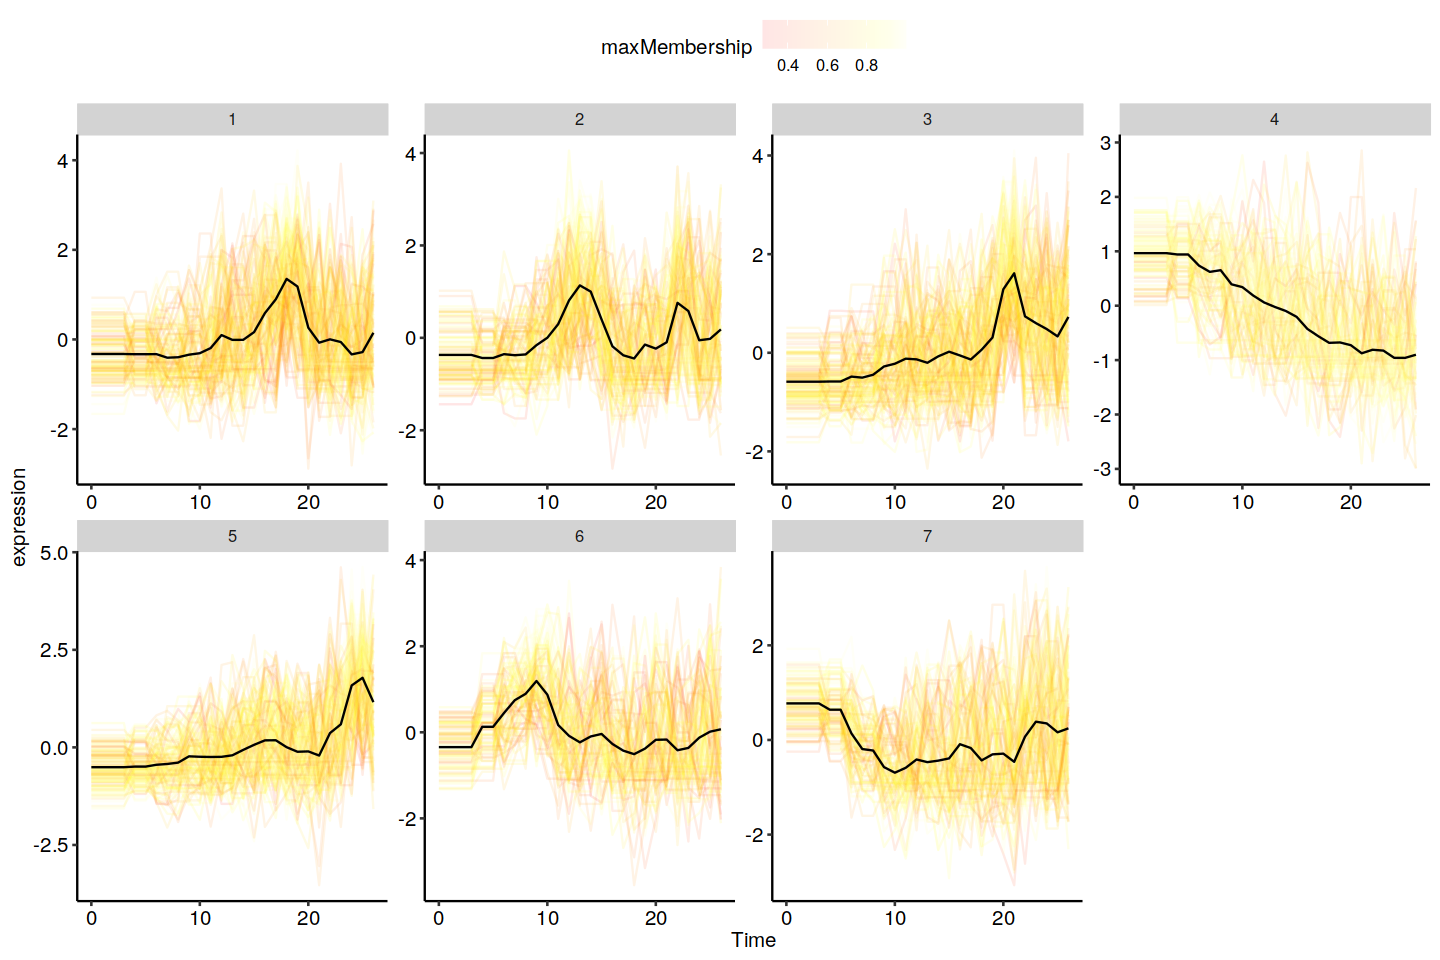

In [19]:
o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

## C1

[1] "Genes:"
Socs1 H2-Q4 Ranbp10 Tef Ddx58 D730003I15Rik Ints2 Map2k6 Pdcd1 Cenpe Zfp784 Selplg Capg Stard5 Lgals1 Xpnpep3 Klra1 Igf1r Sik1 Anxa1 Orai2 Slfn2 Cd300lb Tmem80 Mindy2 Hmgn3 Etv5 Fzr1 Gpr137 Pygl Lpcat2 Fam160b1 Birc5 Grn Serpine2 Galnt12 Nup98 Aldoa Ikzf2 Gadd45a Klf13 Rgcc Ifit2 Gm14302 Dok2 St8sia4 Gpr171 Dpp4 D830025C05Rik Prkx Fcgrt Dennd1c Stat1 Hoxa7 Acvr2b Syk Apobr Tapbp Lyn Ebi3 Vsir Jakmip1 Padi2 9330160F10Rik AC153891.1 Neurl3 Ppm1h Hbb-bt C1qtnf12 Lag3 Gpr146 Pdia5 Slc43a2 Plek Khk Camk2a Cd27 Egfl7 Cd68 Ccnb2 Cdyl2 Msh5 Lrrc25 Prr13 Sh3tc1 Ifnar2 Slc2a6 Gngt2 Tmtc1 Smox Tnfrsf13c Cd300c Hlx Hoxa9 Cd82 Myh9 Anxa2 Glipr1 Snx14 1810021B22Rik Kpna2 2810454H06Rik Evi5 Jaml Tmed3 Stx7 Fbxo6 Man1c1 Gna15 Gse1 Maged1 Rab19 Nr4a2 Lpar6 Sapcd1 Arid5b Nfkbiz Kdm5b Cyp51 Arhgef3 Mxd3 Rnase4 Them6 Kbtbd11 Lat Dnajb9 Ms4a4b Zeb2 Timp2 Kif21bNULL
[1] "TFs:"
Tef Ddx58 Zfp784 Hmgn3 Etv5 Ikzf2 Klf13 Stat1 Hoxa7 Plek Hlx Hoxa9 Kpna2 Nr4a2 Arid5b Nfkbiz Mxd3 Zeb2NULL


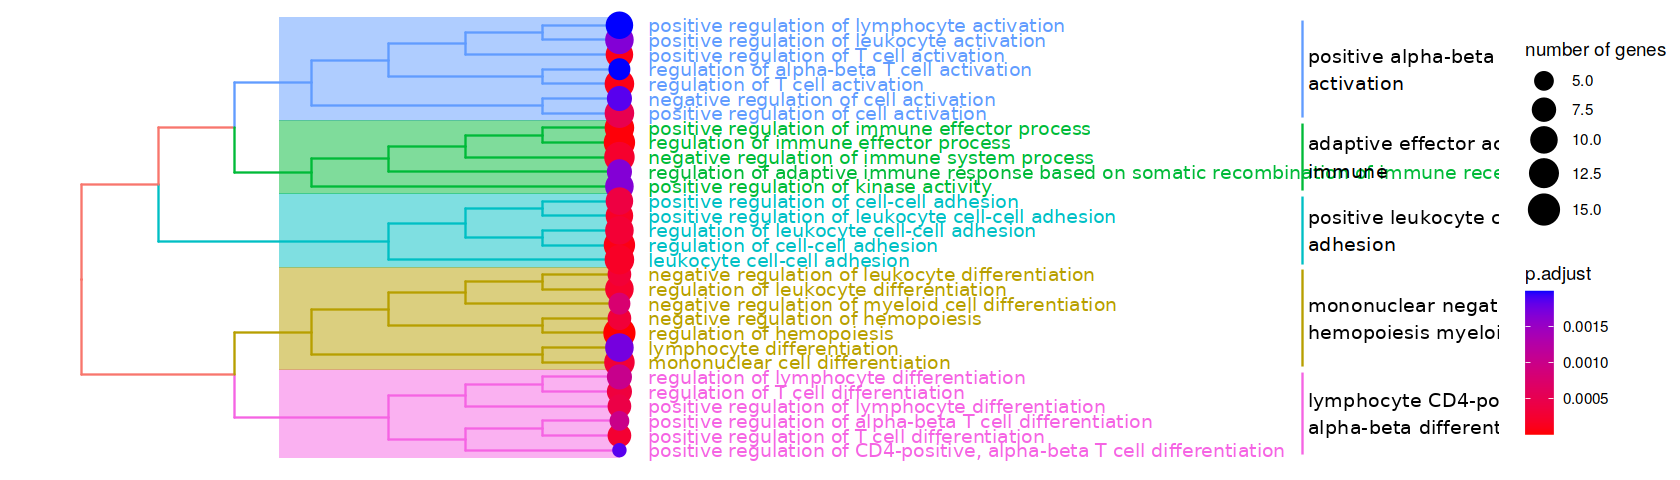

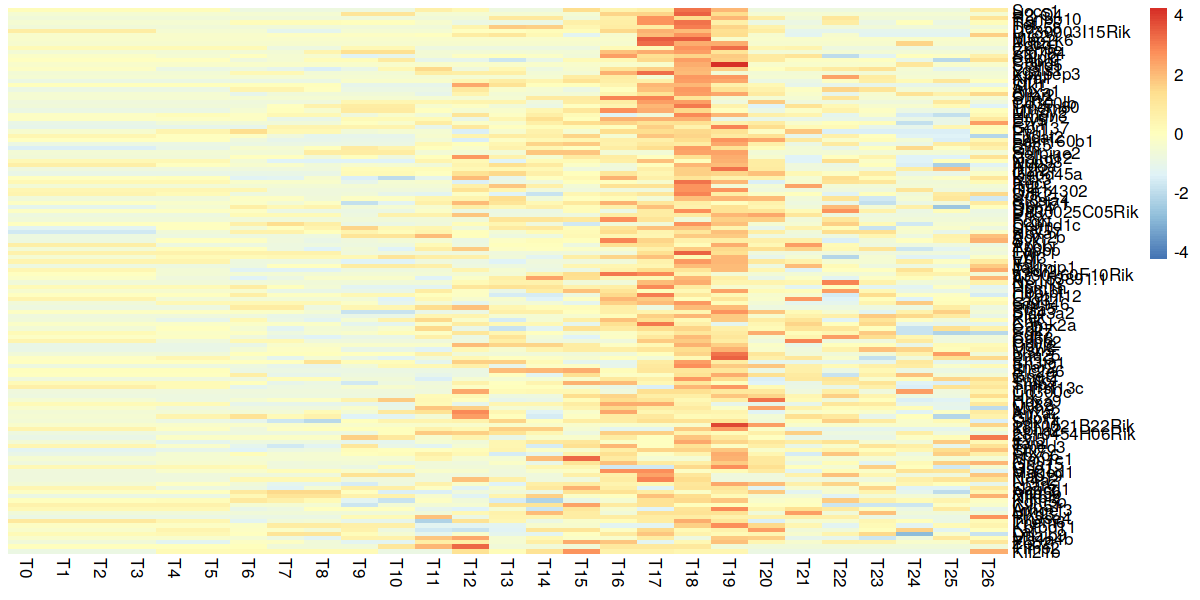

In [20]:
print('Genes:')
print(cat(res1$path.gene))#
print('TFs:')
print(cat(intersect(res1$path.gene, tf)))#

o(14,4)
plot(res1$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res1$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C2

[1] "Genes:"
Cd33 Vegfc Mapk11 Dbt Adcy9 Kif23 Hcst Znfx1 Bambi Phf11c Runx2 Fam46a Ier2 Mmp11 Ms4a4c Gbp5 Nucb2 Alox5ap Gns Gm26947 Nfkbia Hdc Furin Trac Ppm1l Ttf1 Klf6 Iigp1 Itpripl2 Ngp Klhdc1 Cacna2d4 Tspyl2 Ccl6 Gramd3 Rnf122 Zfp85 Il18rap Sgce Tmem176a Zbtb20 Il10ra Mcpt8 Ly6k H2-Oa Phf11b Cd38 Cmpk2 Ighv1-77 Bcl3 Tuba1c Zfp36 S100a8 Ifi206 Spata13 Osbpl7 Cd84 Psrc1 Ceacam1 Mansc1 Hebp1 Egr3 Tspan32 BC022687 Trim26 Junb Isg15 Cdkn2c Fcgr3 Myo1c Xlr3b Dtx3l Pim1 Asah1 Apaf1 Grina Nrp1 Rtp4 H2-K1 Unc13d Dlgap5 Plin3 Itgax Xpr1 Vim Lnx2 Kdm7a Gm47754 Lgals3 Spry1 Neat1 Stoml1 Pi16 Ifih1 Skil Slc46a2 Kctd14 Pqlc3 Spi1 Fbrsl1 Cd3d Syne2 Snx9 Bdh1 Ptprc Izumo4 Rab33b Snhg20 Enc1 Rgl1 Kif20b Gm42418 Myl4 Nr4a1NULL
[1] "TFs:"
Znfx1 Runx2 Nfkbia Ttf1 Klf6 Zfp85 Zbtb20 Bcl3 Zfp36 Egr3 Junb Ifih1 Skil Spi1 Nr4a1NULL


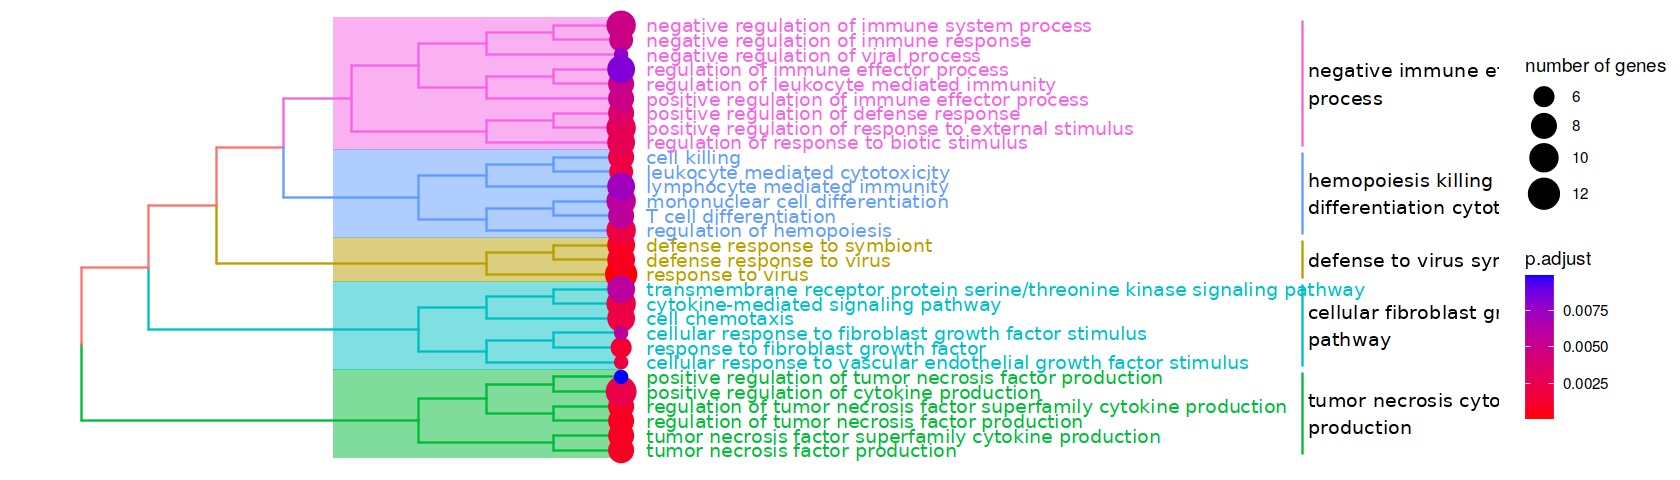

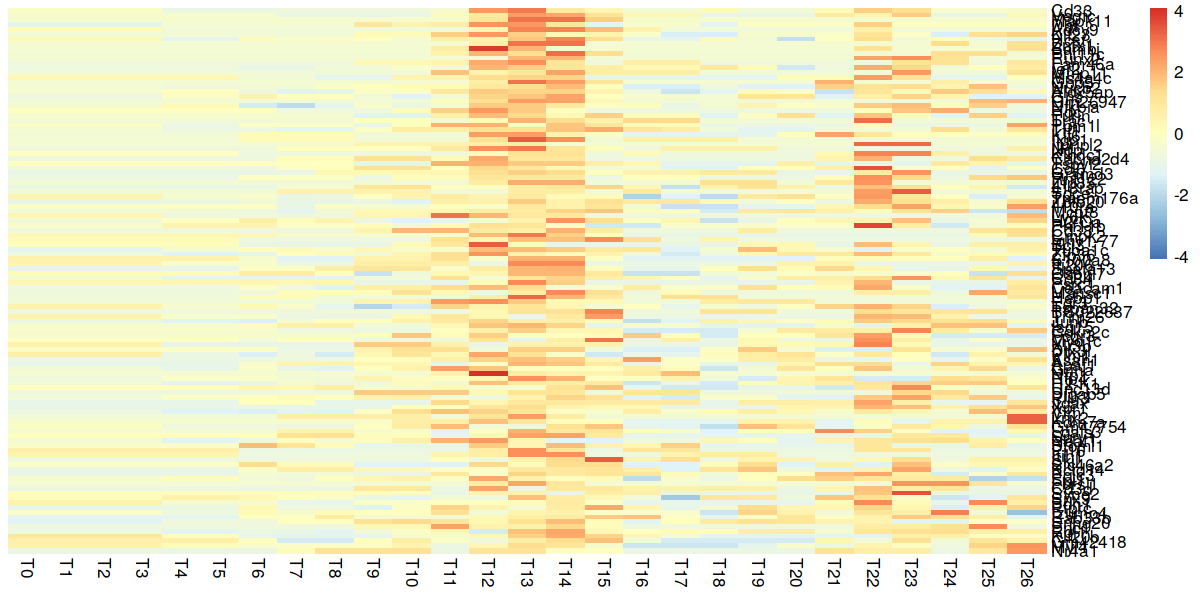

In [21]:
print('Genes:')
print(cat(res2$path.gene))#
print('TFs:')
print(cat(intersect(res2$path.gene, tf)))#

o(14,4)
plot(res2$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res2$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C3

[1] "Genes:"
Tet1 Mir142hg Kdm6b Spib Sesn2 Cdkn2d Srgap3 Fam241a Klrk1 Mmp15 Hist1h2ac Sh2d3c Rhoh S100a9 Runx2os1 Trim8 Tmem119 Net1 Sat1 Pdlim2 3830403N18Rik Selenop Rhob Bmp2k Ddit4 Fcer1g Hpse Hist1h2bc Zeb2os Klrd1 Slc25a53 Notch1 Ap3m2 Ltb Mospd2 Gpcpd1 Calcoco1 Tnfrsf13b Clec12a Gimap6 Ccl4 Gbp8 Siglecg Arrdc4 H2-T23 Unc93b1 H2-DMa Cd63 Cpeb2 Gpr132 Hist3h2ba Atp1a3 Smpdl3a Cnn3 Ltb4r1 Serpinb6b Tnni2 Srebf2 Ctso Tsc22d1 Alcam Cst3 Grhpr Atp6v0a1 Rsrp1 2810001G20Rik Padi1 Arpp21 Ctsh Selenos Txnip Hmga2 Bst2 Cd22 Tmem86a Ebf1 Pbxip1 Slfn8 Epsti1 Herpud1 Yipf2 AC149090.1 Slc9a1 Cyth4 Trp53inp1 Egr1 Pim2 Ccl3 Gm2a Vasp Paqr7 Ighm Abhd17b Arhgap25 Fcor Xbp1 Pear1 Arl5c Tk2 2610035D17Rik Tpm4 Ehbp1l1 Zc3h6 Epha2 Cnn2 Uvssa Blnk Tmcc3 Fam43a Il6ra Stat4 Gm19590 2310001H17Rik 2900026A02Rik Ly86 Hist1h4i Clic4 Gm30054 Psap Sstr2 Lsp1 Cd9 Mgst1 Gm11579 Gm26759 Dnajb14 S100a4 Rgs2 Klrb1f Fos Slc12a9 Card6 H2-M3 Tspyl4 Phf21a Tmem71 Snx29 Anxa5 Blk Cers6 AC147041.1 Chd3 Hspa1a Ctsl Sox4 

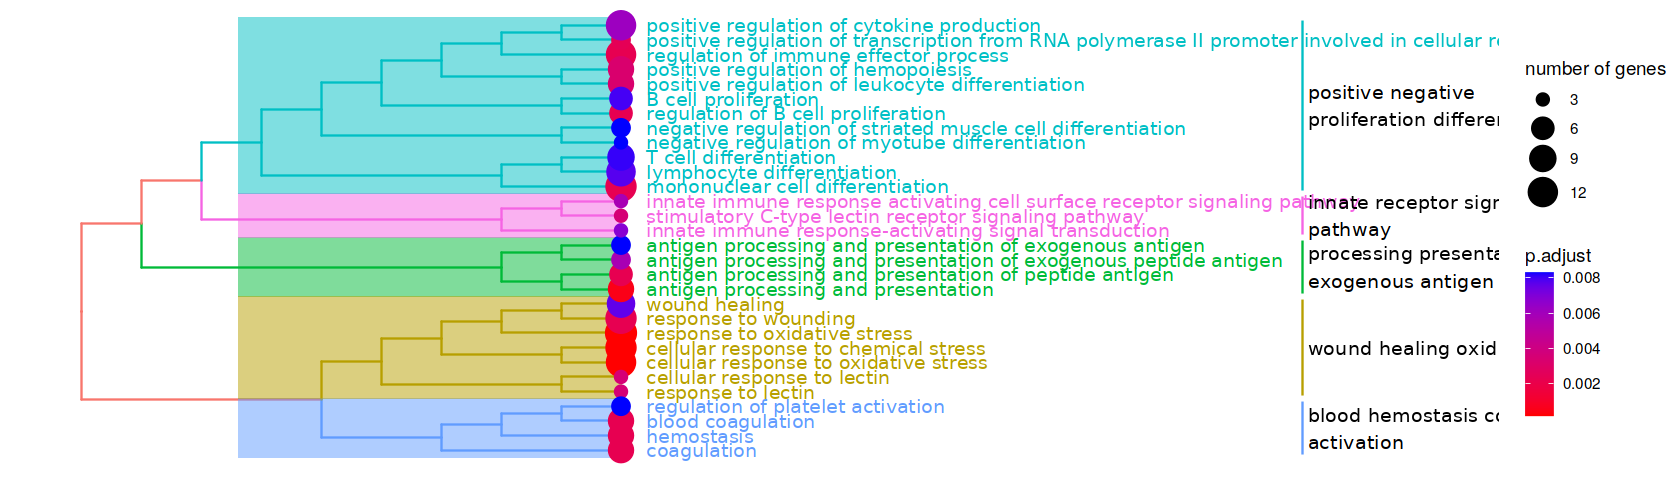

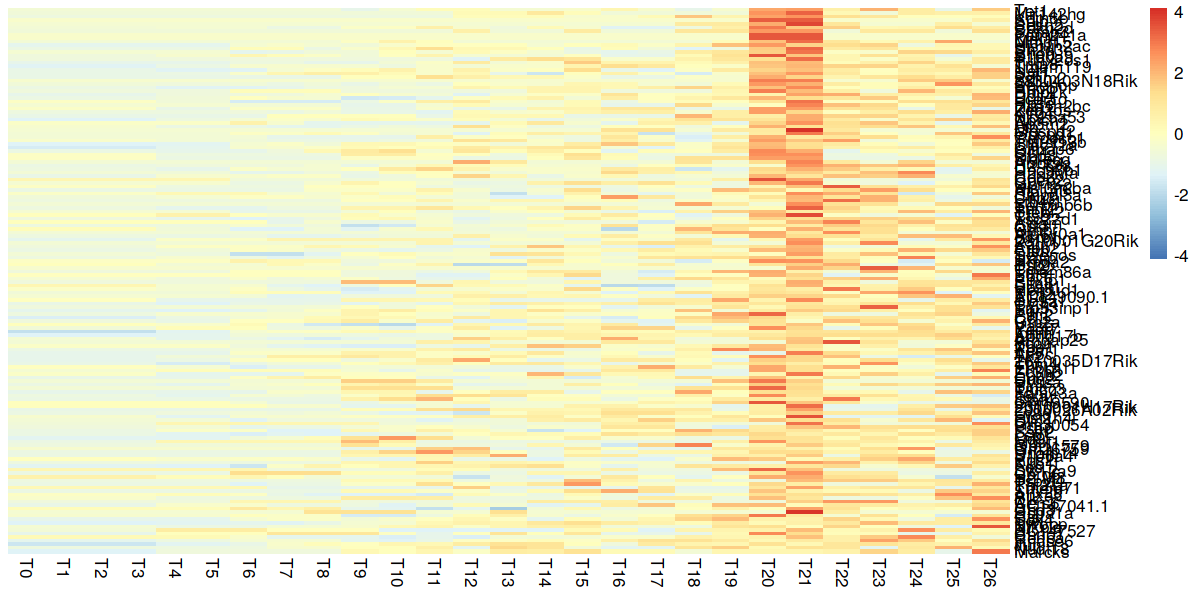

In [22]:
print('Genes:')
print(cat(res3$path.gene))#
print('TFs:')
print(cat(intersect(res3$path.gene, tf)))#

o(14,4)
plot(res3$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res3$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C4

[1] "Genes:"
Cdca7 Tipin Ung Syce2 Dut Tuba1b Stmn1 Mcm3 Ranbp1 Lig1 Cdk1 Tubb5 Sdf2l1 Hells E2f1 Nasp Gmnn Ran Mcm6 Mcm2 Hk2 Uhrf1 Pcna Sqle Ldha H2afz Hmgb2 Ncl Dtl Mcm5 Top2a Clspn Tcf19 Cks1b Mcm7 Dhfr Anp32b Mif Lmnb1 Cycs Mpo Rrm1 Emb Rrm2 Tuba4a Ifitm3 Tk1 Dek Pola2 Prtn3 Srm Rpa2 Tmpo Ezh2 Cd34 Sgo1 Paip2b Hmgb3 Ccne1 Ccne2 Nucks1 Cks2 Pclaf Tyms Fbxo5 Ifitm2 Cdk6 Tpx2 Cdkn1a Ncapd2 Lockd Incenp Spc25 Rexo2 Fabp5 H2afx Tubb4b Acsl1 Mcm4 Crip1 Serpina3g Terf2ip Cd24a Cdc20 Shisa8 Ptprs Cfp Ass1 Ccnd2 Apobec1 Lgmn Il21r Ifi35 Cflar Lgals3bp Jpt1 Ifitm1 Scin Ctla2a Dkkl1 Serpinf1 Anp32e H1fx Mid1ip1 Ccnf Tnni1 Cd6 Calr Tmsb15b1 Hmgn2 Cdk20 Plp2 Spc24 Cyba Cit Car2 Zbp1 Smc4 Mycn P2ry14 1500009L16Rik Npc1 Gm14161 Lst1 Serpinb1a Plpp5 Paip1 Ccnd1 Adora2a Cdv3 Atad2 Aph1c Tfr2 Sept11 Gm26917 Comt Eif2ak2 Adgre5 Relb Dhx58 Fgd2 Gcnt2 Pkib Bub3 Smc2 Pycard Pnck Pdcd4 Lyz2 CtseNULL
[1] "TFs:"
Mcm3 E2f1 Mcm6 Hmgb2 Tcf19 Ezh2 Hmgb3 Mycn Ccnd1 Eif2ak2 Relb Bub3NULL


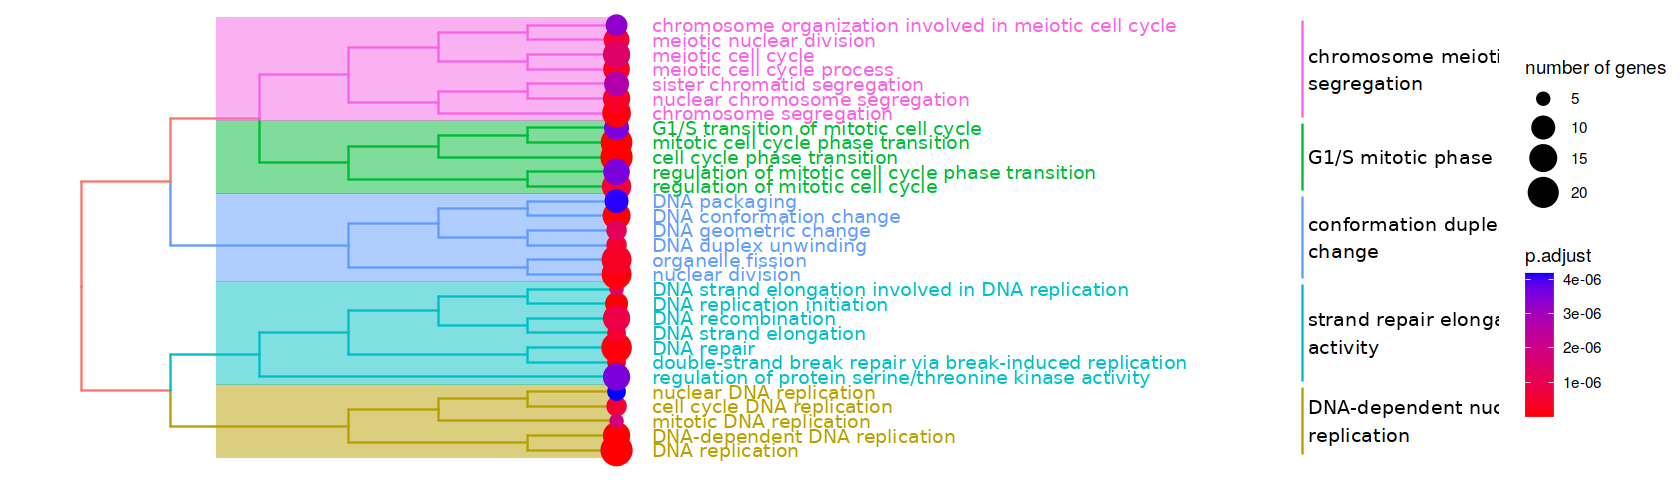

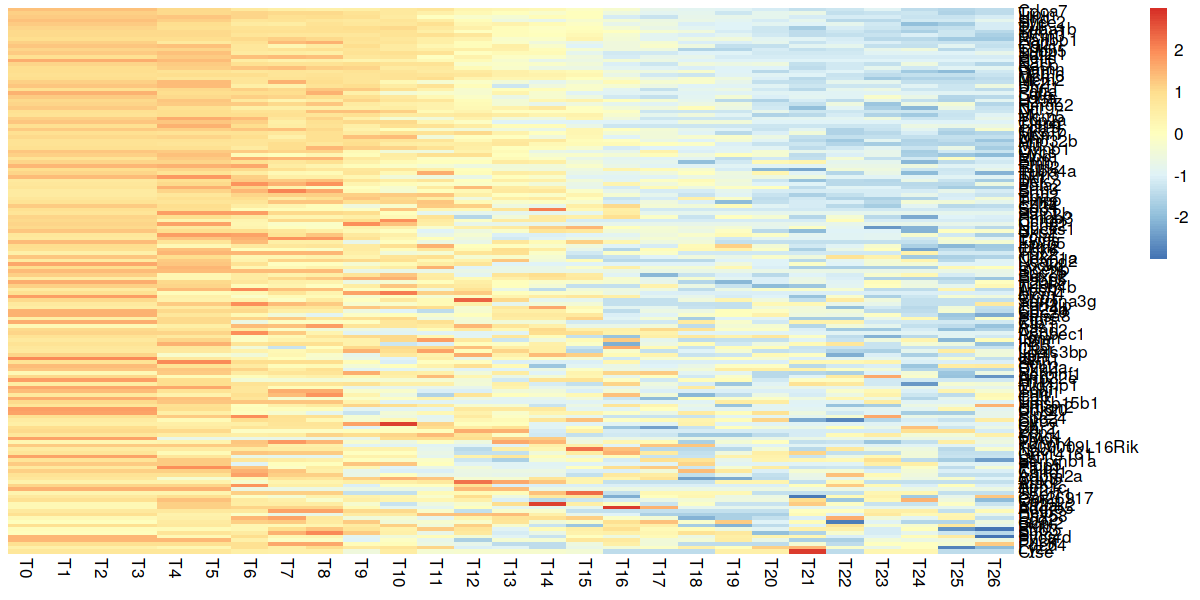

In [23]:
print('Genes:')
print(cat(res4$path.gene))#
print('TFs:')
print(cat(intersect(res4$path.gene, tf)))#

o(14,4)
plot(res4$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res4$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C5

[1] "Genes:"
Calm4 Slfn5 Ccr7 Pdzd4 Clcn5 Mycl Lztfl1 St6gal1 Dyrk4 Trim30b Glis3 Tfrc Rbm47 Tecpr1 Zfhx3 Filip1l Cdkn3 Crybg1 Hes1 AB124611 Gm31243 Platr17 Ifi27l2a Cd3g Tpd52 Gyg Cdk8 Smim5 Gm26532 Cd28 Sdc4 Thy1 Map3k12 Dgka B4galt5 Usp20 Il1r2 Capsl Slc25a40 Yae1d1 Klf7 Shisa5 Gadd45b Cd7 Vangl2 Gm20300 Mn1 Tifab Gm5086 Clec2i Klf2 Gsn Blcap Ly6c2 Kif20a Eva1b Tcp11l2 Nfkb1 Inafm2 Itpr2 Mr1 Nim1k Jund Zrsr1 Nfam1 Smad7 Mxd4 Ppp1r16b Stk17b Plcl2 Gm20234 Icam1 2310035C23Rik Tmem158 Mta3 Ccr9 Sla2 Snx32 Siglech Slamf6 Pygm Hvcn1 Usp18 Vps37a Ier5 Abhd14b Tlr7 Ccnd3 Sp140 Hs3st1 Sdc1 Pik3ip1 Cd200 Gata2 Hsh2d Pkp3 Acadm Irf8 Rpgrip1 Lmo4 Cd244 Rilpl1 B3galnt1 Evl Cnp Tcf7l2 Gimap4 Zcchc18 Agpat3 Uso1 Ptms Stambpl1 Ighd Ppp3ca Ctnnd2 Ap3s1 Pld3 Clec2d Zfp467 Pld4 Prkca Itm2c Dnajc7 Pdk2 Hmgcs1 Cd52 Rrad Ahnak Nrgn Btg2 H2-DMb1 Tsc22d3 Irf7 Ppp3cc Ppfia4 Mpeg1 Cln8 Ctss Rbpms Ctsb Oasl1 Tubgcp5 Tnfaip8l2 Dok3 I830077J02Rik Ahdc1 Ldhb Prss34 Kmo Dusp2 Gstm7 Cox6a2 Itga4 AW112010 Sema4b L

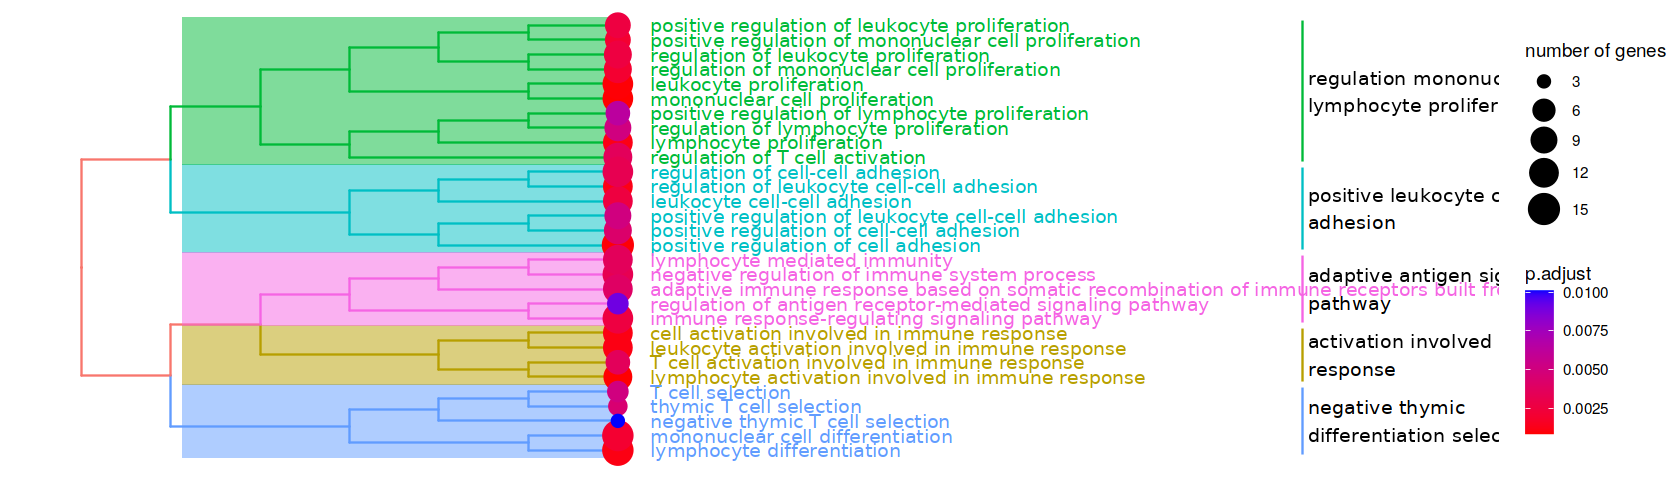

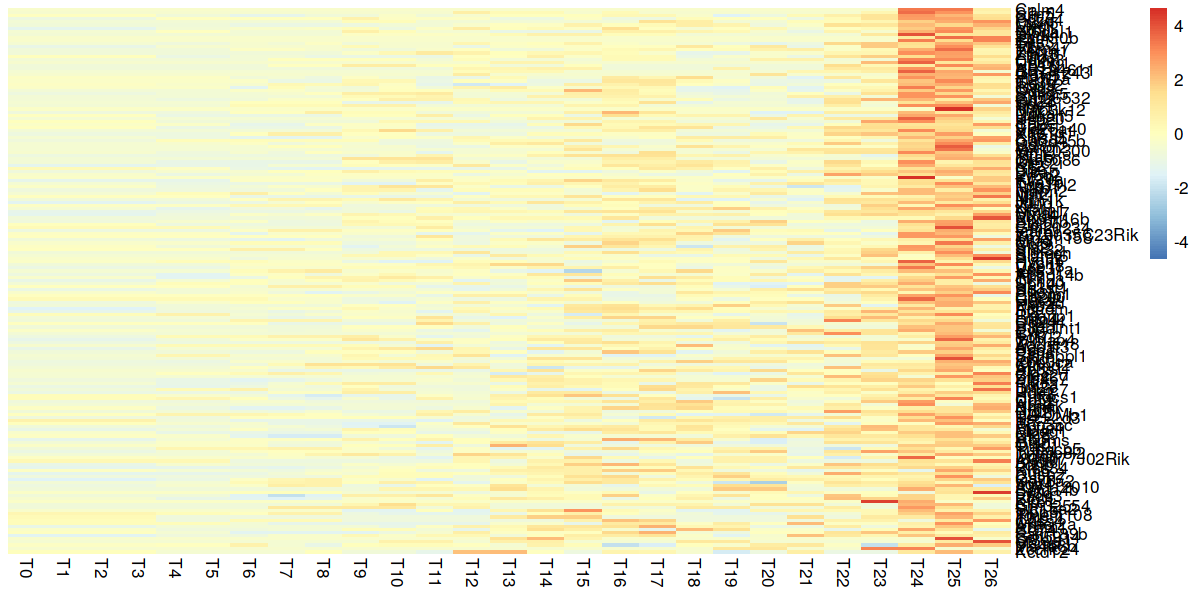

In [24]:
print('Genes:')
print(cat(res5$path.gene))#
print('TFs:')
print(cat(intersect(res5$path.gene, tf)))#

o(14,4)
plot(res5$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res5$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C6

[1] "Genes:"
Sbspon Trib1 Plod2 Fosb Cdca8 Dopey1 Basp1 Tbc1d14 Isoc2b 4732496C06Rik Kifc1 Nsg2 Cdca3 Ccl5 Pik3ap1 Pml Icos Ctsc Jak2 Fam129a Ldlrad3 B930036N10Rik Ckap2l Trf Tex2 Asf1b Gimap5 Klf3 Fam69a Grap Tgtp2 Xaf1 Ctsz Slc2a3 Zfyve28 Gm49359 Paqr5 Sh3bgr Dstn Fam174a Dntt Tep1 Gm17259 Snhg10 Capn5 Usp37 Ube2s Setd4 Abhd6 Fdps Isg20 Lgals9 P2ry12 Racgap1 Nfkbid Noa1 Socs3 Tmem38a Jchain Lpin1 Trp53i11 Trim30a Ifi44 Snx18 Ctla4 Tspan13 Ms4a6c Tbc1d4 Slco3a1 Gprc5b H2afy Fbxl4 S100a6 Hspa5 Rora Fcgr2b Ppp1r15a Cytip Gstt2 Atp1b3 Trim30d Nek6 H2-Q7 Gm11342 Chchd10 Myc Ccnb1 Map3k8 Gpr65NULL
[1] "TFs:"
Fosb Pml Klf3 Rora MycNULL


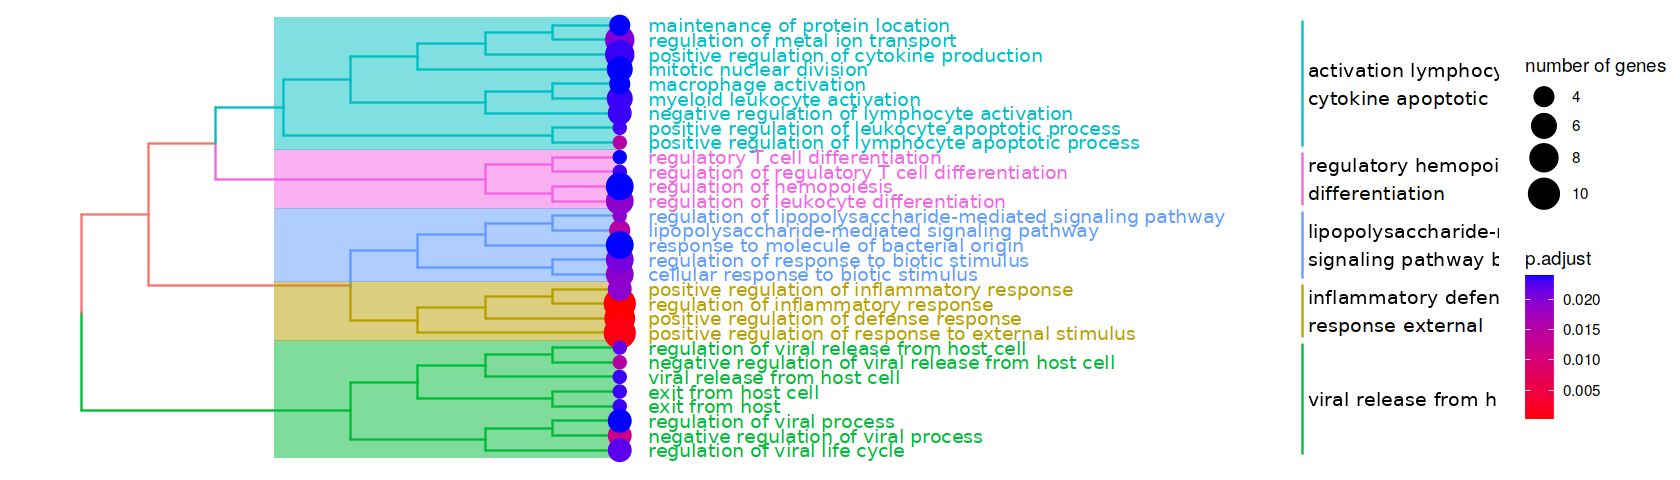

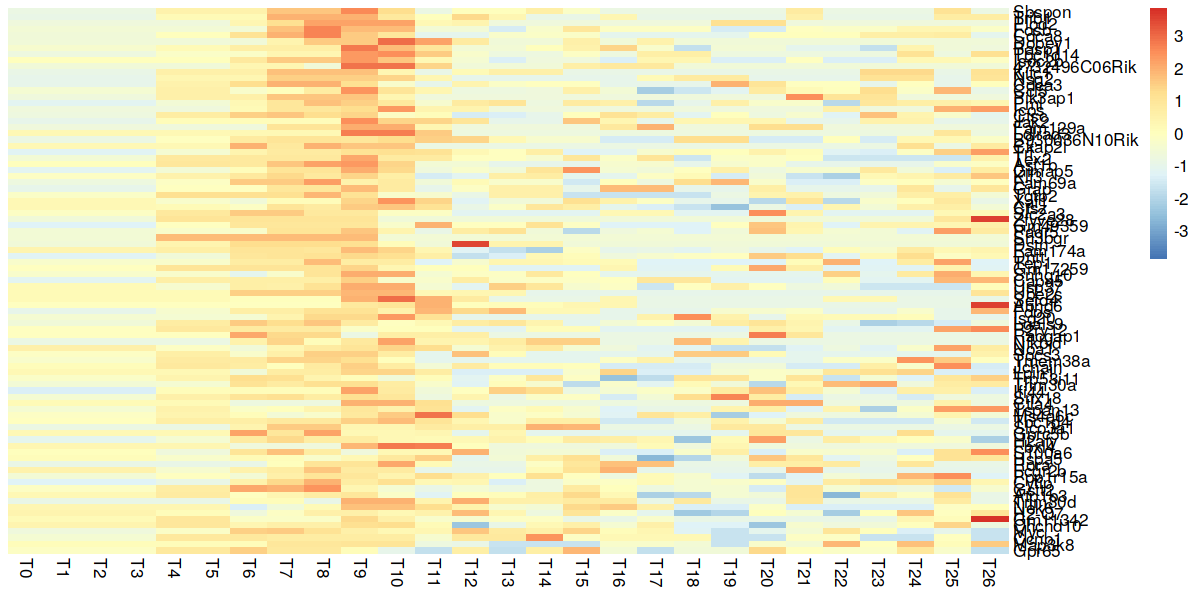

In [25]:
print('Genes:')
print(cat(res6$path.gene))#
print('TFs:')
print(cat(intersect(res6$path.gene, tf)))#

o(14,4)
plot(res6$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res6$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C7

[1] "Genes:"
Slc39a1 Ampd3 H2-Aa Il18r1 Ifi27 Slc35d3 Adam11 Snn 1500011B03Rik Ift57 Fyn Tmc8 Zfp36l1 Rgs1 Nkg7 Etv1 Pmepa1 Card11 4930481A15Rik Lgals8 Gpr18 Calm2 H2-Eb1 Eepd1 Ncoa3 H2-Ab1 Lpgat1 Gm36266 Tpm2 Nfil3 Fam49a Sec24d Ifi203 Pou2f2 Slc30a5 Gm19331 Aurkb Mvb12a Napsa Ccna2 Nde1 Tspo AA467197 Trim12a Abcb4 Gnb4 P2rx4 Carhsp1 Anxa6 Lifr Tmem121 Atp1b1 N4bp2l1 Uvrag 1700097N02Rik Dennd5b Reep4 Ptpre Tmem63a Fyb Tbxa2r B3gnt8 Fgr Cebpb Pvr Gata3 Sytl1 Igfbp4 Gmcl1 Mki67 Arl6ip1 5031425E22Rik Nlrc3 Zfp945 Tox Cd200r1 H2-DMb2 Kynu Mndal Lmo2 Trim5 Sirpa Itgb7 Hbb-bs Dcaf6 Trim12c Sytl3 Ly6e Exoc1 Smarca2 Slpi 4931406C07Rik Rell1 Cpa3 Prdx5 Gm16124 Oasl2 Ccdc122 A630001G21Rik Cd72 Ctsg Pacsin1 Hist1h2ae Cyp2j6 Csf1r Sp100 Gfi1b Cited2 Xlr4a Prag1 Bcl11a Bach2NULL
[1] "TFs:"
Zfp36l1 Etv1 Ncoa3 Nfil3 Pou2f2 Carhsp1 Cebpb Gata3 Zfp945 Tox Lmo2 Smarca2 Sp100 Gfi1b Cited2 Bcl11a Bach2NULL


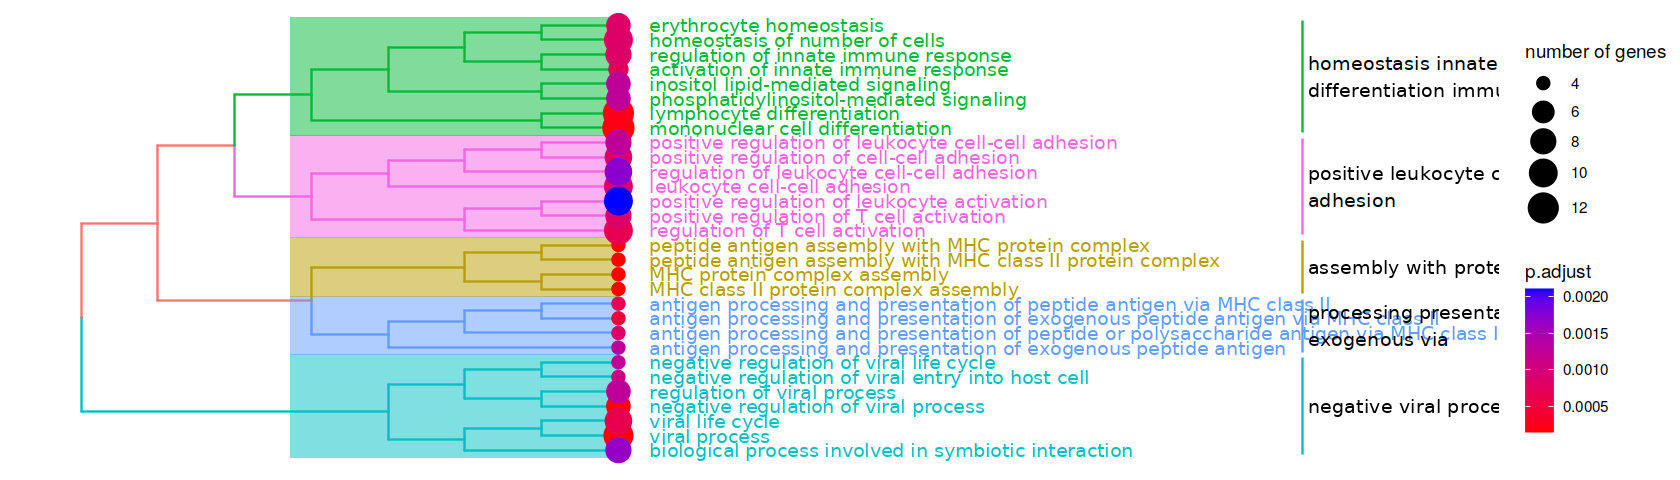

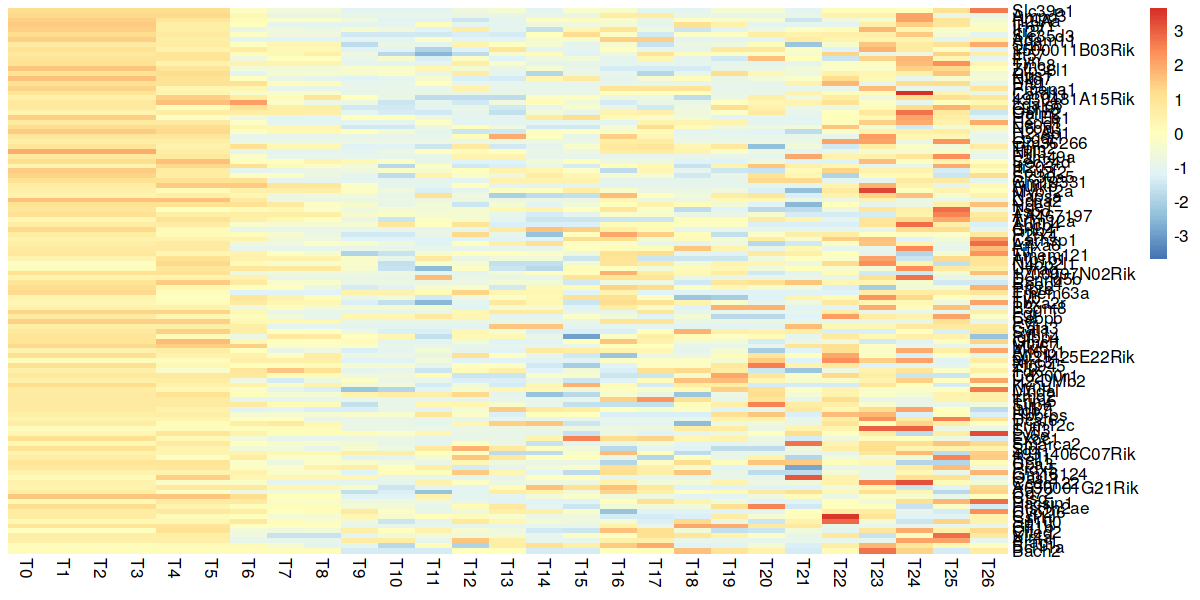

In [26]:
print('Genes:')
print(cat(res7$path.gene))#
print('TFs:')
print(cat(intersect(res7$path.gene, tf)))#

o(14,4)
plot(res7$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res7$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)

